# Chapter 68 (Generative Networks)

### This code generates figures  8, 9, 10, and 12 in Chapter 68: Generative Networks (vol. III)
TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, Cambridge University Press, 2022.

<div style="text-align: justify">
DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
are useful for instructional purposes, they are not intended to serve as examples 
of full-blown or optimized designs. The author has made no attempt at optimizing 
the codes, perfecting them, or even checking them for absolute accuracy. In order 
to keep the codes at a level  that is  easy to follow by students, the author has 
often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
simplicity. Students can use the computer codes to run variations of the examples 
shown in the text. 
</div>

The Jupyter notebook and python codes are developed by Eduardo Faria Cabrera

required libraries:
    
1. numpy
2. matplotlib
3. scipy
4. torch
5. torchvision

The other ones are not necessary

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm

## Example 68.1 (Generation of handwritten digits using a VAE)

We illustrate the operation of the VAE algorithm  by applying it to the problem of learning to generate "handwritten digits" that are similar to the ones arising from the same MNIST dataset considered earlier in Example 65.9. Recall that the MNIST dataset consists of 60,000 labeled training samples. Each entry in the dataset is a 28 $\times$ 28 grayscale image, which we transform into an $M=784-$long feature vector, $h_n$. Each pixel in the image and, therefore, each entry in $h_n$, assumes integer values in the range $[0,255]$. Every feature vector (or image) is assigned an integer label in the range $0$--$9$ depending on which digit the image corresponds to. The earlier Fig. 52.6 showed randomly selected images from the training dataset.

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

path = "./data"
train_data = MNIST(path, transform=transform, download=True, train=True)
test_data = MNIST(path, transform=transform, download=True, train=False)

batch_size = 128
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_datalaoder = DataLoader(test_data, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

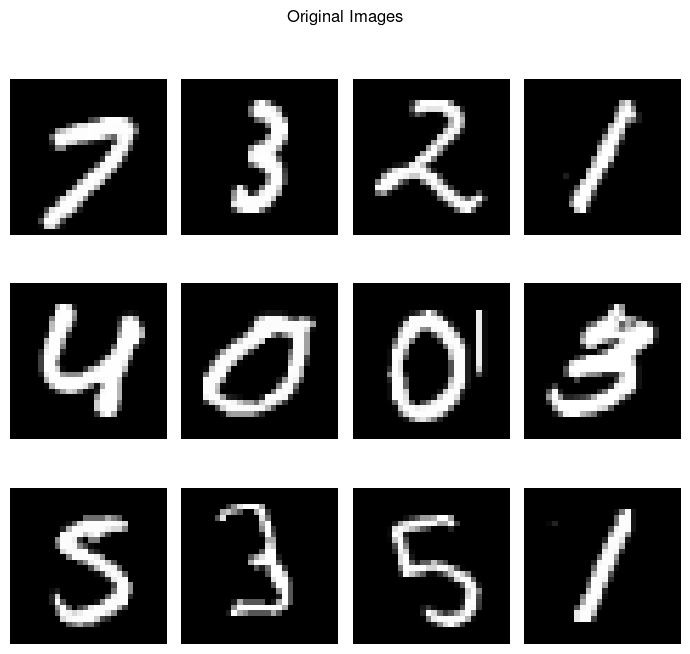

In [6]:
batch_image = next(iter(train_dataloader))
images = [batch_image[0][i, 0] for i in range(12)]

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=7, 7
fig = plt.figure()

for i in range(12):

    img = images[i]
    ax = plt.subplot(3, 4, i+1)
    ax.imshow(img, cmap="gray")
    plt.axis("off")

fig.suptitle("Original Images", fontsize=12)
fig.tight_layout()

plt.savefig("figs/fig-8.pdf", format="pdf", bbox_inches="tight")

plt.show()

**figure 68.9** The plots in the two columns on the left show six randomly selected original images from the MNIST dataset used to train the VAE. The plots in the last two columns on the right show the corresponding approximations generated at the end of the training phase for these images.

We pre-process the images (or the corresponding feature vectors $\{h_n\}$ ) by scaling their entries by $255$ (so that they assume values in the range $[0,1]$). We subsequently compute the mean feature vector for the training set and center the scaled feature vectors around this mean. The earlier Fig. 52.7 showed randomly selected images for the digits $\{0,1\}$ before and after processing.
 
 
We construct a VAE with $L_e= 4$ layers in the encoder stage and $L_d=4$ layers in the decoder stage. In this way, each section has two hidden layers. The size of the input layer for the encoder is $n_{1,e}=784$ (which agrees with the size of the feature vectors), while the size of each of the two hidden layers in the encoder is $n_{2,e}=n_{3,e}=512$ neurons. We set the dimension of the latent vector $u$ to $P=2$ so that the size of the output layer of the encoder is $n_{L_{e},e}=4$. Likewise, the size of the input layer for the decoder  is $n_{1,d}=2$ (which agrees with the size of the latent variable), while the size of each of the two hidden layers in the decoder is again $n_{2,d}=n_{3,d}=512$ neurons. The size of the output layer of the decoder is $n_{L_{d},d}=784$ since it needs to match the size of the input feature vector. 
 
We set the activation functions for all hidden layers in both the encoder and decoder to the ReLu function. However, we set the activation functions at the output layer of the encoder to the $\textit{linear function}$ and at the output layer of the decoder to the tanh function.

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512), # input dim = 28*28, n2e = 512
            nn.ReLU(),
            nn.Linear(512, 512), # n3e = 512
            nn.ReLU()
        )

        self.mean_layer = nn.Linear(512, 2) # mean dim = P = 2
        self.logvar_layer = nn.Linear(512, 2) # logvar dim = P = 2

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 512), # latent variable dim = P = 2, n2d = 512 
            nn.ReLU(),
            nn.Linear(512, 512), # n3d = 512
            nn.ReLU(),
            nn.Linear(512, 28*28), # output dim = input dim = 28*28
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)

        return mean, logvar
    
    def gaussian(self, mean, logvar):
        epsilon = torch.randn_like(logvar).to(device)
        z = mean + torch.exp(logvar)*epsilon

        return z
    
    def decode(self, z):
        x_hat = self.decoder(z)
        
        return x_hat

    def forward(self, x):

        mean, logvar = self.encode(x)

        z = self.gaussian(mean, logvar)

        x_hat = self.decode(z)

        return x_hat, mean, logvar

In [8]:
# creating the loss function

def loss_function(x, x_hat, mean, logvar):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5*torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    return reproduction_loss + KLD

In [9]:
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        epoch_loss = []
        for i, (x, _) in tqdm(enumerate(train_dataloader)):
            x = x.view(x.shape[0], 28*28).to(device)

            optimizer.zero_grad()

            x_hat, mean, logvar = model(x)
            loss = loss_function(x, x_hat, mean, logvar)

            epoch_loss.append(loss.item())

            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}. Average loss: {sum(epoch_loss)/len(epoch_loss)}")
    
    return epoch_loss

In [ ]:
model = VAE().to(device) # creating the model
lr = 1e-3 # step-size
mu = 1e-5 # l2-regularization

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)

epoch_loss = train(model, optimizer, 200, device)

In [11]:
batch_size = 10000
test_datalaoder = DataLoader(test_data, batch_size=batch_size, shuffle=False)

x_test, y_test = next(iter(test_datalaoder))

x_test = x_test.view(x_test.shape[0], 28*28).to(device)

mean, logvar = model.encode(x_test)
z_test = model.gaussian(mean, logvar)

z_test_classes = [z_test[torch.argwhere(y_test == c).reshape(-1)] for c in range(10)]

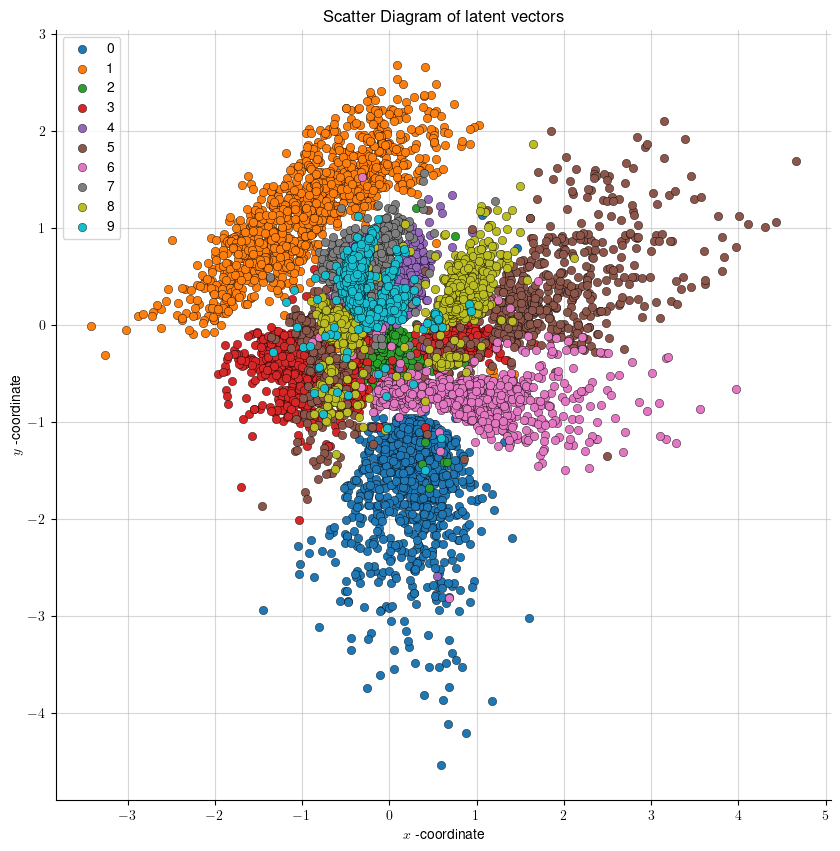

In [12]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=10, 10
fig = plt.figure()

ax = fig.add_subplot(111)

for c in range(10):
    z_test_c = z_test_classes[c]
    ax.scatter(z_test_c[:, 0].detach().numpy(), z_test_c[:, 1].detach().numpy(), label=c, edgecolor="black", linewidth=0.3, zorder=3)

plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
ax.set_title("Scatter Diagram of latent vectors")
ax.set_xlabel("$x$ -coordinate")
ax.set_ylabel("$y$ -coordinate")
plt.legend()

plt.savefig("figs/fig-9.pdf", format="pdf", bbox_inches="tight")

plt.show()

**figure 68.9** The figure plots the latent variables $\{u_n\}$ generated at the end of training for all $60,000$ handwritten digits $\{h_n\}$ in the dataset.  The figure is color-coded so that latent variables corresponding to the same digit value appear in the same color. Observe how the latent variables appear clustered together depending on their digit value.

We train the VAE by using the step-size and regularization parameters: 

$
\mu=0.0001,\;\;\;\rho=0.0001 
$

We run a stochastic-gradient version of the backpropagation algorithm (68.79) with $B=1$. We perform $200$ passes over the training data; the data is randomly reshuffled at the start of each pass. For each input feature vector $h$, we save the value of the latent variable $u$ that was generated at the end of training, after the VAE has converged. Figure 68.8 selects six random feature vectors, $h_n$, and plots them next to the corresponding output vectors, $\widehat{h}_n$, following training. 
In the plots, the grayscale for the images is normalized so that the maximum value in each image is displayed as white, while the minimum value is displayed as black.
 
In Fig. 68.9, we plot a scatter diagram for all  latent variables $\{u_n\}$ that were saved at the end of the training phase for all 60,000 feature samples $\{h_n\}$ from the dataset.  The figure is color-coded so that latent variables corresponding to the same digit value appear in the same color. It is observed that the variables appear clustered together depending on their digit value. We could have  chosen latent variables of higher dimension than $P=2$; we selected this lower value to allow visualization of the clustering effect. Besides, as the subsequent figures show, this low-dimensional latent space is sufficient to illustrate the desired effects and results.
 
During testing, we disconnect the decoder from the encoder. We generate $12$ Gaussian latent variables $u\sim{\cal N}_{u}(0,I_P)$ and feed them into the decoder with the weights and biases fixed at the values obtained at the end of the training phase. We generate the corresponding output vectors $\widehat{h}$ and plot them in image form in Fig. 68.10.  These are  synthetic or fake images!

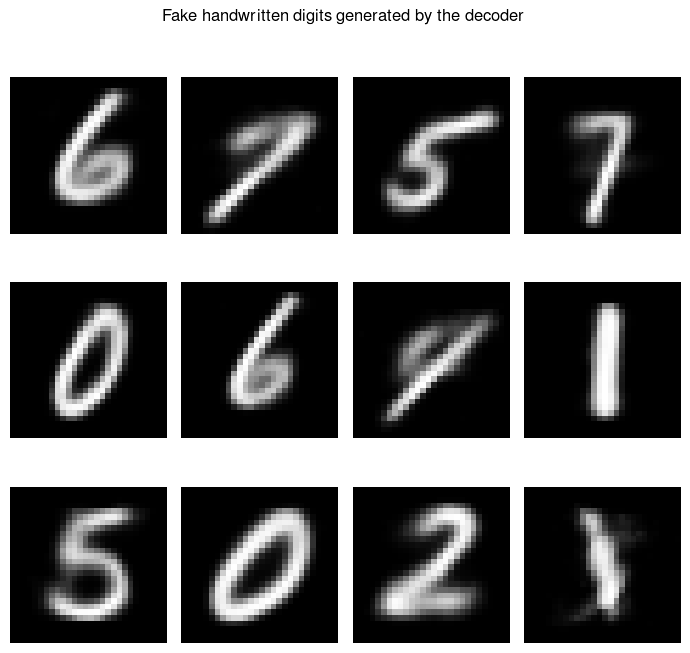

In [13]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=7, 7
fig = plt.figure()

for i in range(12):

    mean = np.random.randn()
    logvar = np.random.randn()
    img = model.decode(torch.tensor([[mean, logvar]])).reshape(28, 28)
    ax = plt.subplot(3, 4, i+1)
    ax.imshow(img.detach().numpy(), cmap="gray")
    plt.axis("off")

fig.suptitle("Fake handwritten digits generated by the decoder", fontsize=12)
fig.tight_layout()

plt.savefig("figs/fig-10.pdf", format="pdf", bbox_inches="tight")

plt.show()

**figure 68.10** Synthetic handwritten images generated by feeding Gaussian latent values $u\sim{\cal N}_{u}(0,I_P)$ through the decoder and plotting the resulting output vectors in image format.

## Example 68.3 (Generation of handwritten digits using a conditional VAE)

We repeat the experiment described in Example 68.1 involving the MNIST database and use the same structures and parameters. Now, however, we train a conditional VAE and use it to generate versions of the digit $3$. The main difference is that we now feed the one-hot encoded label vector into both the encoder and decoder. Figure 68.12 illustrates the generation of synthetic handwritten samples for the digit 3. 

In [14]:
class ConditionalVAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28+10, 512), # input dim = M + C =28*28 + 10, n2e = 512
            nn.ReLU(),
            nn.Linear(512, 512), # n3e = 512
            nn.ReLU()
        )

        self.mean_layer = nn.Linear(512, 2) # mean dim = P = 2
        self.logvar_layer = nn.Linear(512, 2) # logvar dim = P = 2

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2 + 10, 512), # latent variable dim = P + C = 2 + 10, n2d = 512 
            nn.ReLU(),
            nn.Linear(512, 512), # n3d = 512
            nn.ReLU(),
            nn.Linear(512, 28*28), # output dim = input dim = 28*28
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)

        return mean, logvar
    
    def gaussian(self, mean, logvar):
        epsilon = torch.randn_like(logvar).to(device)
        z = mean + torch.exp(logvar)*epsilon

        return z
    
    def decode(self, z):
        x_hat = self.decoder(z)
        
        return x_hat

    def forward(self, x, y):

        x_ = torch.concat([x, y], axis=-1)

        mean, logvar = self.encode(x_)

        z = self.gaussian(mean, logvar)

        z_ = torch.concat([z, y], axis=-1)

        x_hat = self.decode(z_)

        return x_hat, mean, logvar

In [15]:
def train_conditional(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        epoch_loss = []
        for i, (x, y) in tqdm(enumerate(train_dataloader)):
            x = x.view(x.shape[0], 28*28).to(device)
            y = torch.nn.functional.one_hot(y)

            optimizer.zero_grad()

            x_hat, mean, logvar = model(x, y)
            loss = loss_function(x, x_hat, mean, logvar)

            epoch_loss.append(loss.item())

            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}. Average loss: {sum(epoch_loss)/len(epoch_loss)}")
    
    return epoch_loss

In [ ]:
conditional_model = ConditionalVAE().to(device) # creating the model
lr = 1e-3 # step-size
mu = 1e-5 # l2-regularization

optimizer = torch.optim.Adam(conditional_model.parameters(), lr=lr, weight_decay=mu)

epoch_loss = train_conditional(conditional_model, optimizer, 200, device)

In [17]:
batch_size = 10000
test_datalaoder = DataLoader(test_data, batch_size=batch_size, shuffle=False)

x_test, y_test = next(iter(test_datalaoder))

x_test = x_test.view(x_test.shape[0], 28*28).to(device)

y_test_ = torch.nn.functional.one_hot(y_test)

x_test_ = torch.concat([x_test, y_test_], axis=-1)

mean, logvar = conditional_model.encode(x_test_)
z_test = conditional_model.gaussian(mean, logvar)

z_test_classes = [z_test[torch.argwhere(y_test == c).reshape(-1)] for c in range(10)]

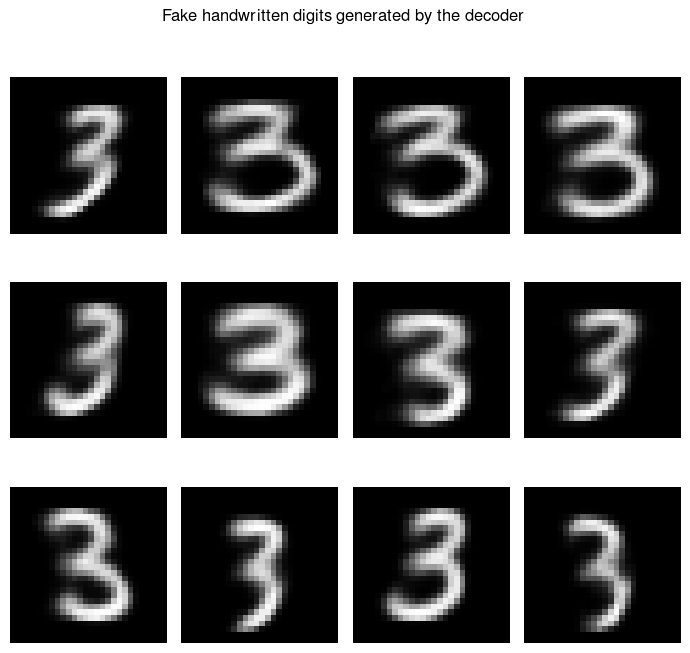

In [18]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=7, 7
fig = plt.figure()

for i in range(12):

    mean = np.random.randn()
    logvar = np.random.randn()
    y = torch.nn.functional.one_hot(torch.tensor([3]), num_classes=10)
    z = torch.concat([torch.tensor([[mean, logvar]]), y], axis=-1)
    img = conditional_model.decode(z).reshape(28, 28)
    ax = plt.subplot(3, 4, i+1)
    ax.imshow(img.detach().numpy(), cmap="gray")
    plt.axis("off")

fig.suptitle("Fake handwritten digits generated by the decoder", fontsize=12)
fig.tight_layout()

plt.savefig("figs/fig-12.pdf", format="pdf", bbox_inches="tight")

plt.show()

**figure 68.12** Synthetic handwritten images of the digit 3 generated by feeding Gaussian latent variables $u\sim{\cal N}_{u}(0,I_P)$ into the encoder and the label $\gamma=e_4$ ($4$th basis vector with a unit entry at the $4$th location) into both the encoder and decoder.

## Generate Figure 68.16

There is, however, one difficulty with maximizing (68.124). During the early stages of training, when the fake data produced by the generator has not been "perfected" yet, the discriminator will be able to separate them with relative ease from the real data. That is, during the early stages of training it is likely that $\widehat{\gamma}_n(1)\approx 0$ for $n\in{\cal N}_f$. This is problematic because the function $\ln(1-x)$ has gradient close to zero when $x\rightarrow 0$; this effect is illustrated in Fig. 68.16. The vanishingly small gradient near $\widehat{\gamma}_n(1)\approx 0$ will slow down the training of the generator. For this reason, in practice, the empirical risk  for the generator is modified and problem (68.124) is replaced by

$
\Bigl\{W_{\ell,g}^{\star},\theta_{\ell,g}^{\star}\Bigr\}=
{\underset{\{W_{\ell,g},\theta_{\ell,g}\}}{\textnormal{argmax}}} \left\{\sum_{\ell=1}^{L_g-1}\rho\|W_{\ell,g}\|_{F}^2+\frac{1}{N}
\sum_{n\in{\cal N}_f}
\ln\left(\widehat{\gamma}_n(1)\right)\right\}
$

This modification does not alter the overall goal for the generator, which is to drive $\widehat{\gamma}_n(1)$ to 1.  Clearly, by changing the risk function for the generator, the underlying game is no longer zero-sum since one payoff is not the opposite of the other anymore. Nevertheless, this adjustment is necessary to enable proper learning and avoid the vanishing gradient problem.

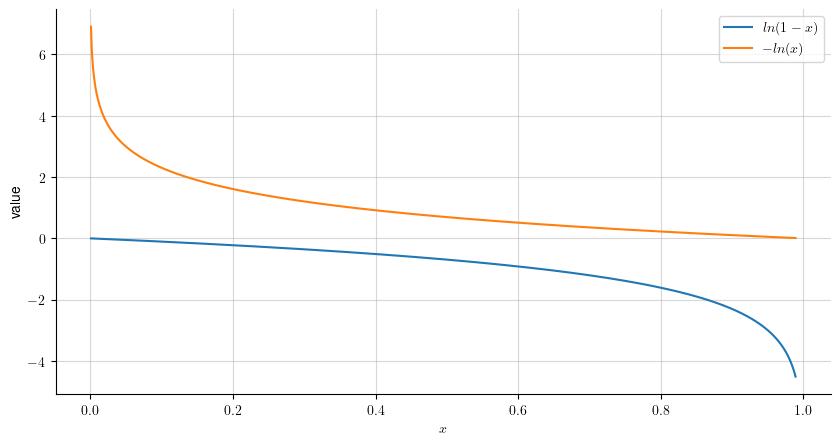

In [6]:
# Generating figure 16
x = np.arange(0.001, 0.99, 0.001)

y1 = np.log(1-x)
y2 = -np.log(x)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=10, 5
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
ax.plot(x, y1, label="$ln(1-x)$")
ax.plot(x, y2, label="$-ln(x)$")

ax.set_ylabel("value")
ax.set_xlabel("$x$")

plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()

plt.savefig("figs/fig-16.pdf", format="pdf", bbox_inches="tight")

plt.show()

**figure 68.16** The function $\ln(1-x)$ is practically flat close to $x=0$, which causes a vanishing gradient problem during training by backpropagation. This problem is alleviated by replacing $\ln(1-x)$ by $-\ln(x)$ in the risk function as explained in (68.125). This alternative function is not flat around $x=0$.

## Example 68.6 (Generation of handwritten digits using a GAN)

We reconsider the same MNIST database from Example 68.1 and train a GAN to generate synthetic handwritten digits. However, we preprocess the data so that the normalized feature vectors assume values in the range $[-1,1]$, since the activation functions at the output layer of the generator are set to the tanh function.
 
We construct a GAN with $L_g= 5$ layers in the generator stage and $L_d=5$ layers in the discriminator stage. In this way, each layer has three hidden layers. The size of the input layer for the generator is $n_{1,g}=2$, which is the size of the latent variable ($P=2$), while the size of each of the three hidden layers in the generator is $n_{2,g}=256,$ $n_{3,g}=512,$ and $n_{4,g}=1024$ neurons. Likewise, the size of the input layer to the discriminator is $n_{1,d}=784$, which is the size of the feature vectors, while the size of each of the three hidden layers is 
 $n_{2,d}=1024,$ $n_{3,d}=512$, and $n_{4,g}=256$ neurons. The size of the output layer of the discriminator is  $n_{L_{d},d}=2$ (i.e., $Q=2$).

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

path = "./data"
train_data = MNIST(path, transform=transform, download=True, train=True)
test_data = MNIST(path, transform=transform, download=True, train=False)

batch_size = 128
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_datalaoder = DataLoader(test_data, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(100 + 10, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):

        x = self.layers(z)

        return x
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(10 + 28*28, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):

        y = self.layers(x)

        return y

In [18]:
def plot_img(array,number=None):

    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": "Helvetica",
    })

    plt.rcParams['figure.figsize']=5, 5
    fig = plt.figure()

    for i, (img, n) in enumerate(zip(array, number)):
        img = img.detach()
        img = img.reshape(28,28)
        ax = fig.add_subplot(1, 3, i+1)

        ax.imshow(img,cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        if number:
            ax.set_xlabel(n,fontsize='x-large')
    plt.show()

In [14]:
def train(generator, discriminator, generator_optimizer, discriminator_optimizer, epochs, device, loss_function, train_steps):
    generator.train()
    discriminator.train()
    for epoch in range(epochs):

        for t_step in tqdm(range(train_steps)):

            discriminator_optimizer.zero_grad()
            x_real, classes_real = next(iter(train_dataloader))
            x_real = x_real.view(x_real.shape[0], 28*28).to(device)
            classes_one_hot = nn.functional.one_hot(classes_real, num_classes=10)

            x_real = torch.concat([x_real, classes_one_hot], dim=-1)
            discriminator_real_out = discriminator(x_real)
            discriminator_real_loss = loss_function(discriminator_real_out.squeeze(), torch.ones(x_real.shape[0]))
            discriminator_real_loss.backward()

            latent_variables = torch.randn((x_real.shape[0], 100)).to(device)
            latent_class = torch.randint(0, 10, (latent_variables.shape[0], ))
            latent_class_one_hot = nn.functional.one_hot(latent_class, num_classes=10)
            latent_x = torch.concat([latent_variables, latent_class_one_hot], dim=-1)
            x_fake = generator(latent_x)
            x_fake = torch.concat([x_fake, latent_class_one_hot], dim=-1)
            discriminator_fake_out = discriminator(x_fake)
            discriminator_fake_loss = loss_function(discriminator_fake_out.squeeze(), torch.zeros(x_real.shape[0]))
            discriminator_fake_loss.backward()
            discriminator_optimizer.step()

            generator_optimizer.zero_grad()

            latent_variables = torch.randn((x_real.shape[0], 100)).to(device)
            latent_class = torch.randint(0, 10, (latent_variables.shape[0], ))
            latent_class_one_hot = nn.functional.one_hot(latent_class, num_classes=10)
            latent_x = torch.concat([latent_variables, latent_class_one_hot], dim=-1)
            generator_out = generator(latent_x)
            generator_out_x = torch.concat([generator_out, latent_class_one_hot], dim=-1)
            discriminator_out = discriminator(generator_out_x)
            generator_loss = loss_function(discriminator_out.squeeze(), torch.ones(generator_out.shape[0]))
            generator_loss.backward()
            generator_optimizer.step()

        if epoch % 10 == 0:
            plot_img([generator_out[0], generator_out[1], generator_out[2]], [latent_class[0].item(), latent_class[1].item(), latent_class[2].item()])

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:09<00:00, 10.18it/s]


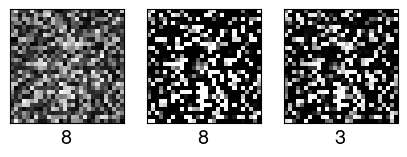

100%|██████████| 100/100 [00:09<00:00, 10.15it/s]


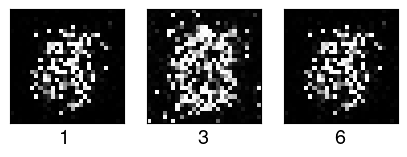

100%|██████████| 100/100 [00:09<00:00, 10.15it/s]


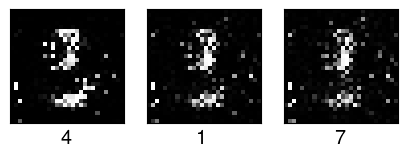

100%|██████████| 100/100 [00:09<00:00, 10.16it/s]


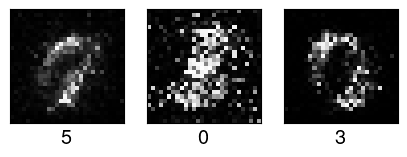

100%|██████████| 100/100 [00:09<00:00, 10.14it/s]


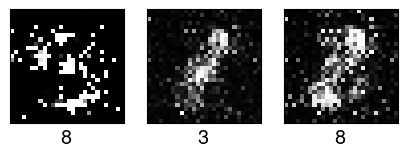

100%|██████████| 100/100 [00:09<00:00, 10.11it/s]


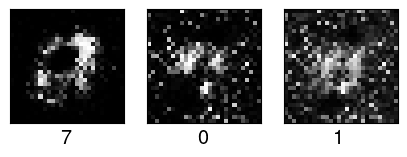

100%|██████████| 100/100 [00:09<00:00, 10.10it/s]


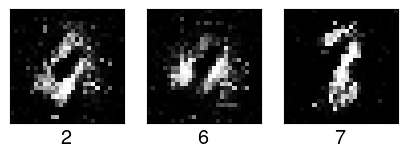

100%|██████████| 100/100 [00:09<00:00, 10.16it/s]


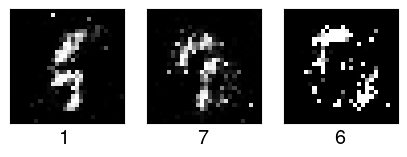

100%|██████████| 100/100 [00:09<00:00, 10.16it/s]


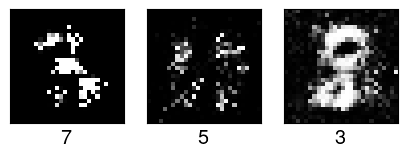

100%|██████████| 100/100 [00:09<00:00, 10.21it/s]


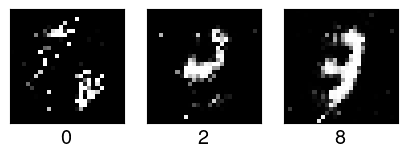

100%|██████████| 100/100 [00:09<00:00, 10.17it/s]


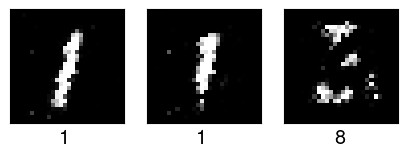

100%|██████████| 100/100 [00:09<00:00, 10.16it/s]


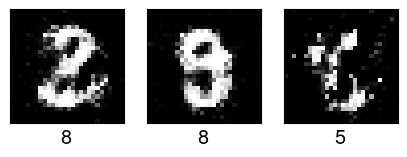

100%|██████████| 100/100 [00:09<00:00, 10.15it/s]


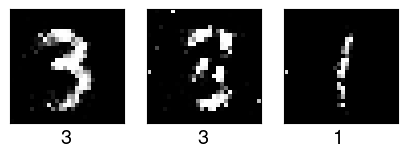

100%|██████████| 100/100 [00:09<00:00, 10.12it/s]


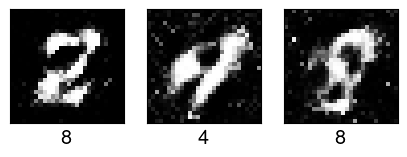

100%|██████████| 100/100 [00:09<00:00, 10.08it/s]


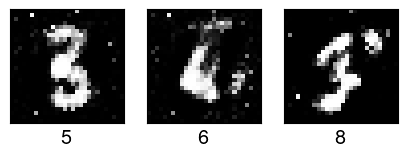

100%|██████████| 100/100 [00:09<00:00, 10.05it/s]


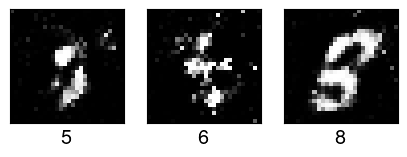

100%|██████████| 100/100 [00:09<00:00, 10.10it/s]


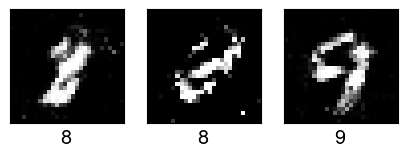

100%|██████████| 100/100 [00:09<00:00, 10.11it/s]


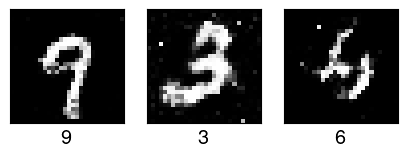

100%|██████████| 100/100 [00:09<00:00, 10.03it/s]


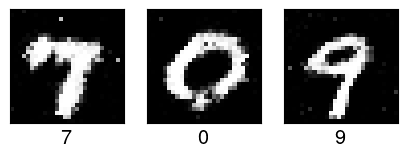

100%|██████████| 100/100 [00:09<00:00, 10.09it/s]


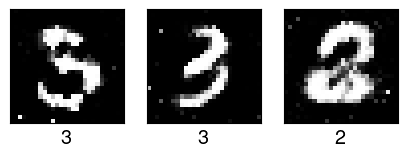

100%|██████████| 100/100 [00:09<00:00, 10.09it/s]


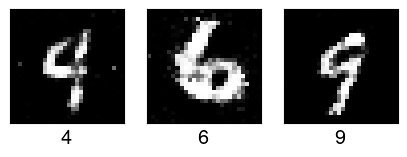

100%|██████████| 100/100 [00:09<00:00, 10.10it/s]


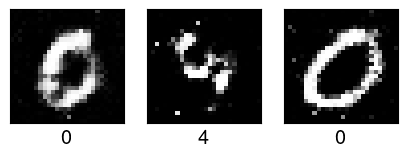

100%|██████████| 100/100 [00:09<00:00, 10.12it/s]


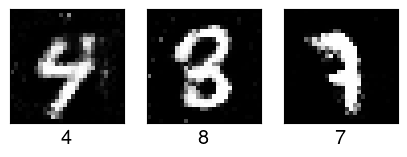

100%|██████████| 100/100 [00:09<00:00, 10.09it/s]


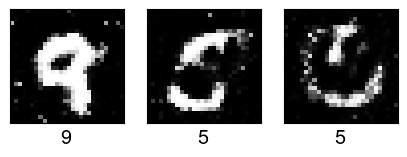

100%|██████████| 100/100 [00:09<00:00, 10.13it/s]


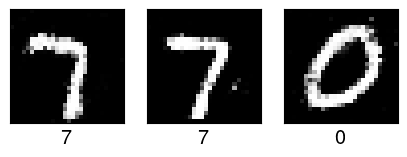

100%|██████████| 100/100 [00:09<00:00, 10.09it/s]


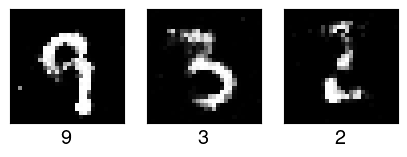

100%|██████████| 100/100 [00:09<00:00, 10.10it/s]


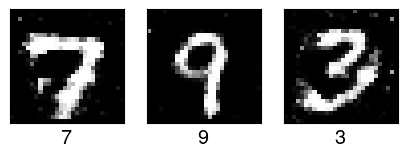

100%|██████████| 100/100 [00:09<00:00, 10.05it/s]


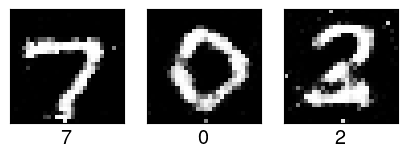

100%|██████████| 100/100 [00:09<00:00, 10.07it/s]


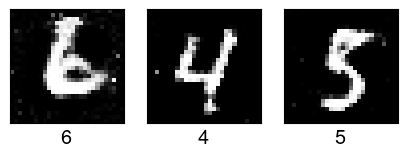

100%|██████████| 100/100 [00:09<00:00, 10.12it/s]


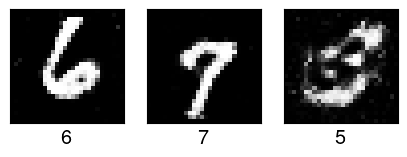

100%|██████████| 100/100 [00:09<00:00, 10.13it/s]


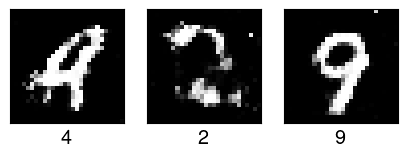

100%|██████████| 100/100 [00:09<00:00, 10.02it/s]


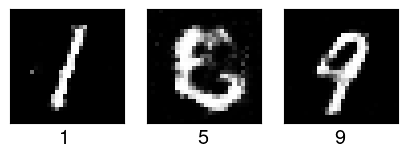

100%|██████████| 100/100 [00:09<00:00, 10.03it/s]


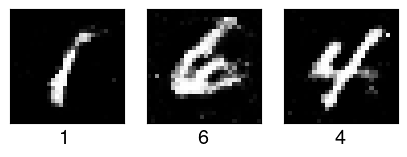

100%|██████████| 100/100 [00:09<00:00, 10.09it/s]


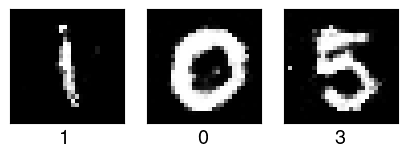

100%|██████████| 100/100 [00:09<00:00, 10.02it/s]


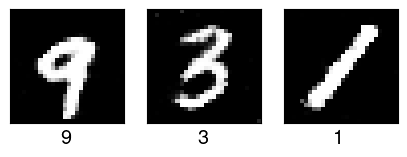

100%|██████████| 100/100 [00:10<00:00,  9.56it/s]


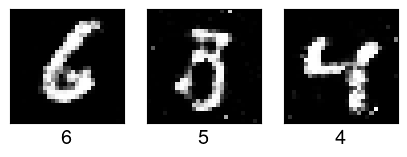

100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


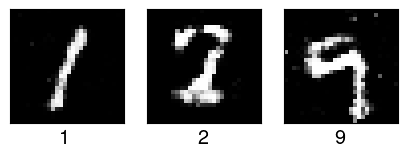

100%|██████████| 100/100 [00:09<00:00, 10.06it/s]


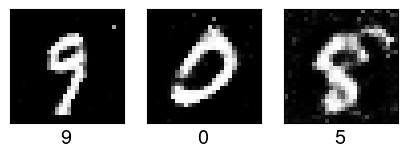

100%|██████████| 100/100 [00:09<00:00, 10.11it/s]


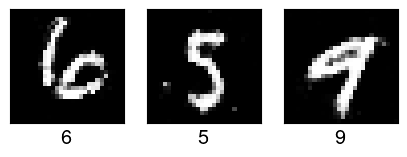

100%|██████████| 100/100 [00:10<00:00,  9.99it/s]


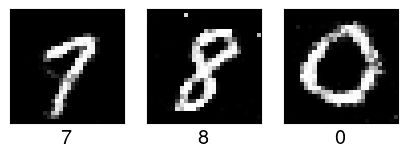

100%|██████████| 100/100 [00:10<00:00,  9.56it/s]


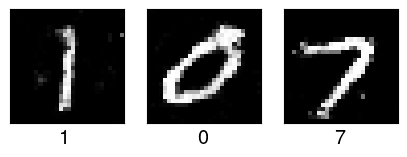

100%|██████████| 100/100 [00:09<00:00, 10.19it/s]


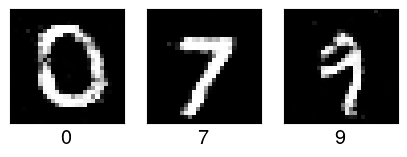

100%|██████████| 100/100 [00:09<00:00, 10.21it/s]


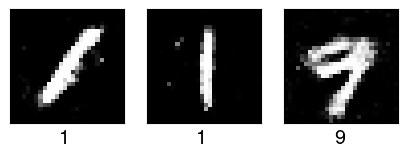

100%|██████████| 100/100 [00:09<00:00, 10.24it/s]


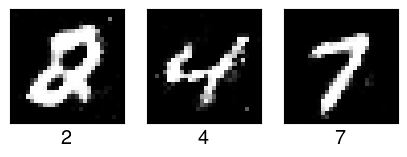

100%|██████████| 100/100 [00:09<00:00, 10.23it/s]


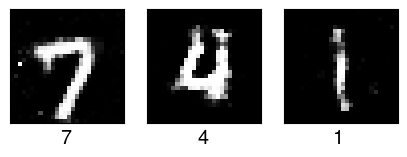

100%|██████████| 100/100 [00:09<00:00, 10.25it/s]


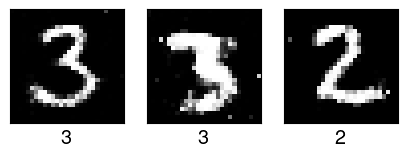

100%|██████████| 100/100 [00:09<00:00, 10.18it/s]


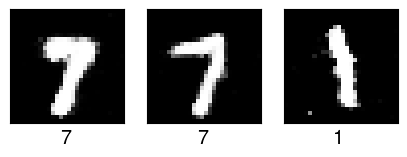

100%|██████████| 100/100 [00:09<00:00, 10.19it/s]


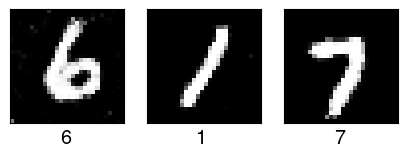

100%|██████████| 100/100 [00:09<00:00, 10.18it/s]


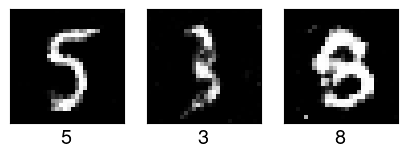

100%|██████████| 100/100 [00:09<00:00, 10.16it/s]


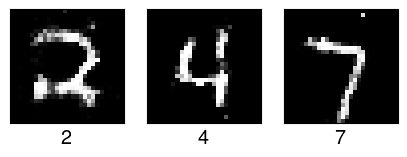

100%|██████████| 100/100 [00:09<00:00, 10.21it/s]


In [20]:
generator = Generator()
discriminator = Discriminator()

lr = 1e-4

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

loss_function = torch.nn.BCELoss()

train(generator, discriminator, generator_optimizer, discriminator_optimizer, 500, device, loss_function, 100)

In [78]:
latent_variables = torch.randn((36, 100)).to(device)
latent_class = torch.randint(0, 10, (latent_variables.shape[0], ))
latent_class_one_hot = nn.functional.one_hot(latent_class, num_classes=10)
latent_x = torch.concat([latent_variables, latent_class_one_hot], dim=-1)
generator_out = generator(latent_x)
imgs = generator_out.reshape(36, 28, 28)

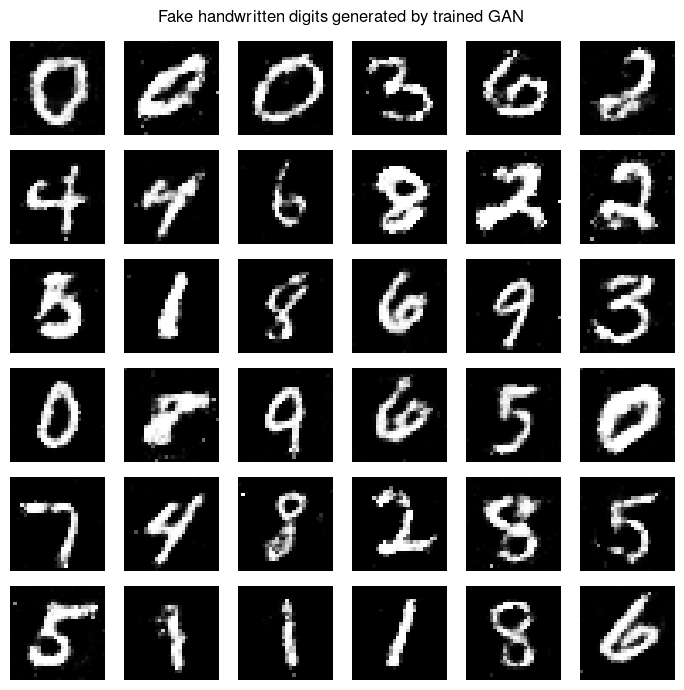

In [81]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=7, 7
fig = plt.figure()

for i in range(36):

    img = imgs[i].detach()
    ax = plt.subplot(6, 6, i+1)
    ax.imshow(img.detach().numpy(), cmap="gray")
    plt.axis("off")

fig.suptitle("Fake handwritten digits generated by trained GAN", fontsize=12)
fig.tight_layout()

plt.savefig("figs/fig-20.pdf", format="pdf", bbox_inches="tight")

plt.show()

**figure 68.20** Synthetic handwritten images generated by feeding Gaussian latent values $u\sim{\cal N}_{u}(0,I_P)$ through the generator of a trained GAN and plotting the resulting output vectors in image format. 

We set the activation functions for all hidden layers in both the generator and discriminator to the ReLu function. However, we set the activation function at the output layer of the generator to the tanh function  and at the output layer of the discriminator to the softmax function.
 
We train the GAN using the ADAM recursions (instead of the stochastic-gradient recursions; we explained earlier in Example 65.3 what adjustments are necessary to run ADAM). We employ the following step-size, regularization, and forgetting factor parameters: 

$
\mu=0.0002,\;\;\;\rho=0.0001 \\
\beta_{w,1}=\beta_{\theta,1}=0.500,\;\;\;\;(\textnormal{for ADAM implementation})\\
\beta_{w,2}=\beta_{\theta,2}=0.999\\
\epsilon=1\times 10^{-8}
$

We run an ADAM version of the backpropagation algorithm (68.160)--(68.161) with mini-batches of size $B=128$ samples. We also set $K_d=K_g=1$. We perform $200$ passes over the training data; the data is randomly reshuffled at the start of each pass. The weight parameters are initialized according to the schemes 
(65.93b)--(65.93c).

 
The training of GANs is generally difficult and it can fail in many ways due to the competition between the discriminator and generator modules. Sources of instability include the vanishing gradient effect and the $\textit{mode collapse problem}$, where the GAN ends up producing only one or a small subset of images regardless of the input latent vector (this behavior is apparent in Fig. 68.20). Also, during the initial stages of training when the generator has not yet perfected the generation of images that can fool the discriminator, the latter will be able to easily discriminate between real and fake images. Some ad-hoc techniques that can help ameliorate these convergence problems are (a) to decrease the value of the step-size parameter; (b) to add some small zero-mean Gaussian noise to the real or fake feature vectors $\{h_n,\widehat{h}_n\}$ that are fed into the discriminator during training; and (c) to use soft (or smooth) labels for the real features during training, such as setting $\gamma_n=\textnormal{col}\{0.9,0\}$ when $h_n$ is real instead of the hard value at $\gamma_n=\textnormal{col}\{1,0\}$. These techniques interfere with the learning ability of the discriminator and provide an opportunity for the generator to improve its performance.
 
In the plot, the grayscale for the images is normalized so that the maximum value in each image is displayed as white, while the minimum value is displayed as black. During testing, we disconnect the generator from the discriminator. We  generate $256$ Gaussian latent variables $u\sim{\cal N}_{u}(0,I_P)$ and feed them into the generator with the weights and biases fixed at the values obtained at the end of the training phase. We generate the corresponding output vectors $\widehat{h}$ and plot them in image form in Fig. 68.20.  These are artificially generated (fake or synthetic) images. 